In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import scanpy, networkx, scprep, magic, phate, scipy, DiffusionEMD, pygsp, torch, sklearn
import rpy2, rpy2.situation, anndata2ri
from localization import * #Wavelet module

In [2]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/gpfs/ysm/home/fc489/yaleCollab


In this notebook we will compute a wavelet dictionary on the KGlrp version 2.
We are now using a GCN approach to generate the embeddings from which we will compute a gene-gene knn graph on which to compute the wavelet dictionary used during cell projection.

# Data ingestion

## KGE

In [3]:
dKGlrp = pd.read_csv(f"{data_dir}/dKGlrp_v2.csv.tar.gz", header=None)
dKGlrp

,0,1,2
0,TGFB1,Signaling by TGFB family members,TGFBR1
1,TGFB1,Signaling by TGFB family members,TGFBR2
2,TGFB2,Signaling by TGFB family members,TGFBR1
3,TGFB2,Signaling by TGFB family members,TGFBR2
4,TGFB3,Signaling by TGFB family members,TGFBR1
...,...,...,...
480,ACVR1C,Signaling by TGFB family members,p-\S+-SMAD(2|3)
481,RHO,Signaling by TGFB family members,p-\S+-SMAD(2|3)
482,AR,Signaling by TGFB family members,p-\S+-SMAD(2|3)
483,LTB,Signaling by TGFB family members,p-\S+-SMAD(2|3)


In [4]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

modelKGE = "KGlrp2_50_unstratified_stopped_RGCN"

tf = TriplesFactory.from_labeled_triples(
        dKGlrp.to_numpy(dtype="str"),create_inverse_triples=("inverse" in modelKGE))
print(tf)
entityIDS = tf.entity_id_to_label
relationIDS = tf.relation_id_to_label

try:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
except RuntimeError:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl",
    map_location=torch.device("cpu"))

print(trained_model)

TriplesFactory(num_entities=95, num_relations=2, create_inverse_triples=False, num_triples=485)
RGCN(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): DistMultInteraction()
  (entity_representations): ModuleList(
    (0): RGCNRepresentation(
      (entity_embeddings): Embedding(
        (_embeddings): Embedding(95, 50)
      )
      (edge_weighting): SymmetricEdgeWeighting()
      (layers): ModuleList(
        (0): RGCNLayer(
          (fwd): BasesDecomposition(
            (relation_representations): LowRankRepresentation(
              (bases): Embedding(
                (_embeddings): Embedding(2, 2500)
              )
            )
          )
          (bwd): BasesDecomposition(
            (relation_representations): LowRankRepresentation(
              (bases): Embedding(
                (_embeddings): Embedding(2, 2500)
              )
            )
          )
          (self_loop): Linear(in_features=50, out_features=50, bias=True)
          (

In [5]:
#Construct nodes dataframe: detach() for now is meaningless as compute is CPU
entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()
dKGEnodes_50 = pd.DataFrame(entity_embeddings, index=entityIDS.values())
dKGEnodes_50

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
ACVR1,0.661193,-0.667579,0.151677,0.525785,0.254360,-0.628382,0.667595,0.433907,-0.638313,0.032112,...,0.255684,-0.887183,0.498549,-0.422302,0.688557,-0.279119,0.440986,0.411817,-0.428140,-0.267098
ACVR1B,0.581314,-0.512175,0.153713,0.557406,0.167536,-0.575056,0.582852,0.333460,-0.554057,-0.234389,...,0.325372,-0.811509,0.447056,-0.277806,0.593301,-0.300828,0.429395,0.309851,-0.377173,-0.256332
ACVR1C,0.560601,-0.500342,0.014936,0.481937,0.086058,-0.350113,0.596627,0.312245,-0.514775,0.054447,...,0.186235,-0.510140,0.242183,-0.233123,0.537843,-0.311603,0.332775,0.198119,-0.266719,-0.240193
ACVR2A,0.692938,-0.619116,0.160284,0.438733,0.307177,-0.499086,0.615899,0.349416,-0.565733,0.174502,...,0.301017,-0.773386,0.378213,-0.372950,0.637653,-0.387999,0.495762,0.306046,-0.361903,-0.208154
ACVR2B,0.583322,-0.575121,0.152332,0.494262,0.154768,-0.419175,0.611752,0.292560,-0.506832,0.099409,...,0.253552,-0.668959,0.381742,-0.388745,0.500867,-0.414063,0.458546,0.297512,-0.303669,-0.211960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p-\S*S473\S*-AKT1,0.112507,0.495764,-0.838548,-0.162478,-0.558683,0.732159,-0.091883,-0.753614,0.265748,1.829969,...,0.722683,0.036685,-0.724752,0.024715,0.016745,-0.815245,-0.120884,-0.483761,0.520171,-0.769884
p-\S*T308\S*-AKT1,0.205895,0.515429,-0.756942,-0.180259,-0.558515,0.851403,-0.069688,-0.808189,0.127706,1.752207,...,0.752516,-0.217559,-0.510722,-0.015105,-0.035204,-0.817442,-0.079596,-0.544389,0.520321,-0.889245
p-\S+-MAPK(3|1)\s+,0.874641,-0.571101,0.140335,1.682521,-0.991395,-0.870981,1.230430,0.907135,-0.690567,-0.069457,...,-0.403049,1.358842,-1.187621,0.925419,0.786932,-0.583261,-0.633351,0.053290,-0.562098,0.873219
p-\S+-SMAD(1|5|9),0.742144,-0.614508,0.140307,1.348926,-0.905811,-0.773813,1.214121,0.880647,-0.722301,0.237303,...,-0.448192,1.264056,-1.191389,0.856771,0.640615,-0.502169,-0.680609,-0.042236,-0.467633,0.767940


## Load scRNAseq data

In [6]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Calling `R RHOME`: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/c

In [7]:
anndata2ri.activate() #This HAS TO be run b4 loading the rpy2 extension
%load_ext rpy2.ipython

In [8]:
%%R -i data_dir -o dRnaSeq,dPHATEcoord
library(tidyverse)
library(Seurat)

d_fibWT = readRDS(paste0(data_dir,"/Omics/","d_fibWT.rds"))
d_fibWT@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibWT)
#Convert seurat object to anndata
dRnaSeq = as.SingleCellExperiment(d_fibWT)
#Export PHATE coordinates
dPHATEcoord = as.data.frame(Embeddings(d_fibWT, reduction = "phate"))

rm(d_fibWT)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

R[write to console]: Attaching SeuratObject

R[write to console]: Attaching sp



An object of class Seurat 
40940 features across 3698 samples within 2 assays 
Active assay: RNA (20867 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate


/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/python3.9/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


AxisArrays with keys: 
Before filtering we have 20867 genes
After filtering genes expressed in fewer than 4 cells we have 20666


AnnData object with n_obs × n_vars = 3698 × 20666
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'mito_content', 'rfp_content', 'gfp_content', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CCDiff', 'SCT_snn_res.0.6', 'seurat_clusters', 'curatedCLUST', 'old.clust', 'finalPOPS', 'ident'
    var: 'n_cells'
    obsm: 'X_PHATE'
    layers: 'logcounts'

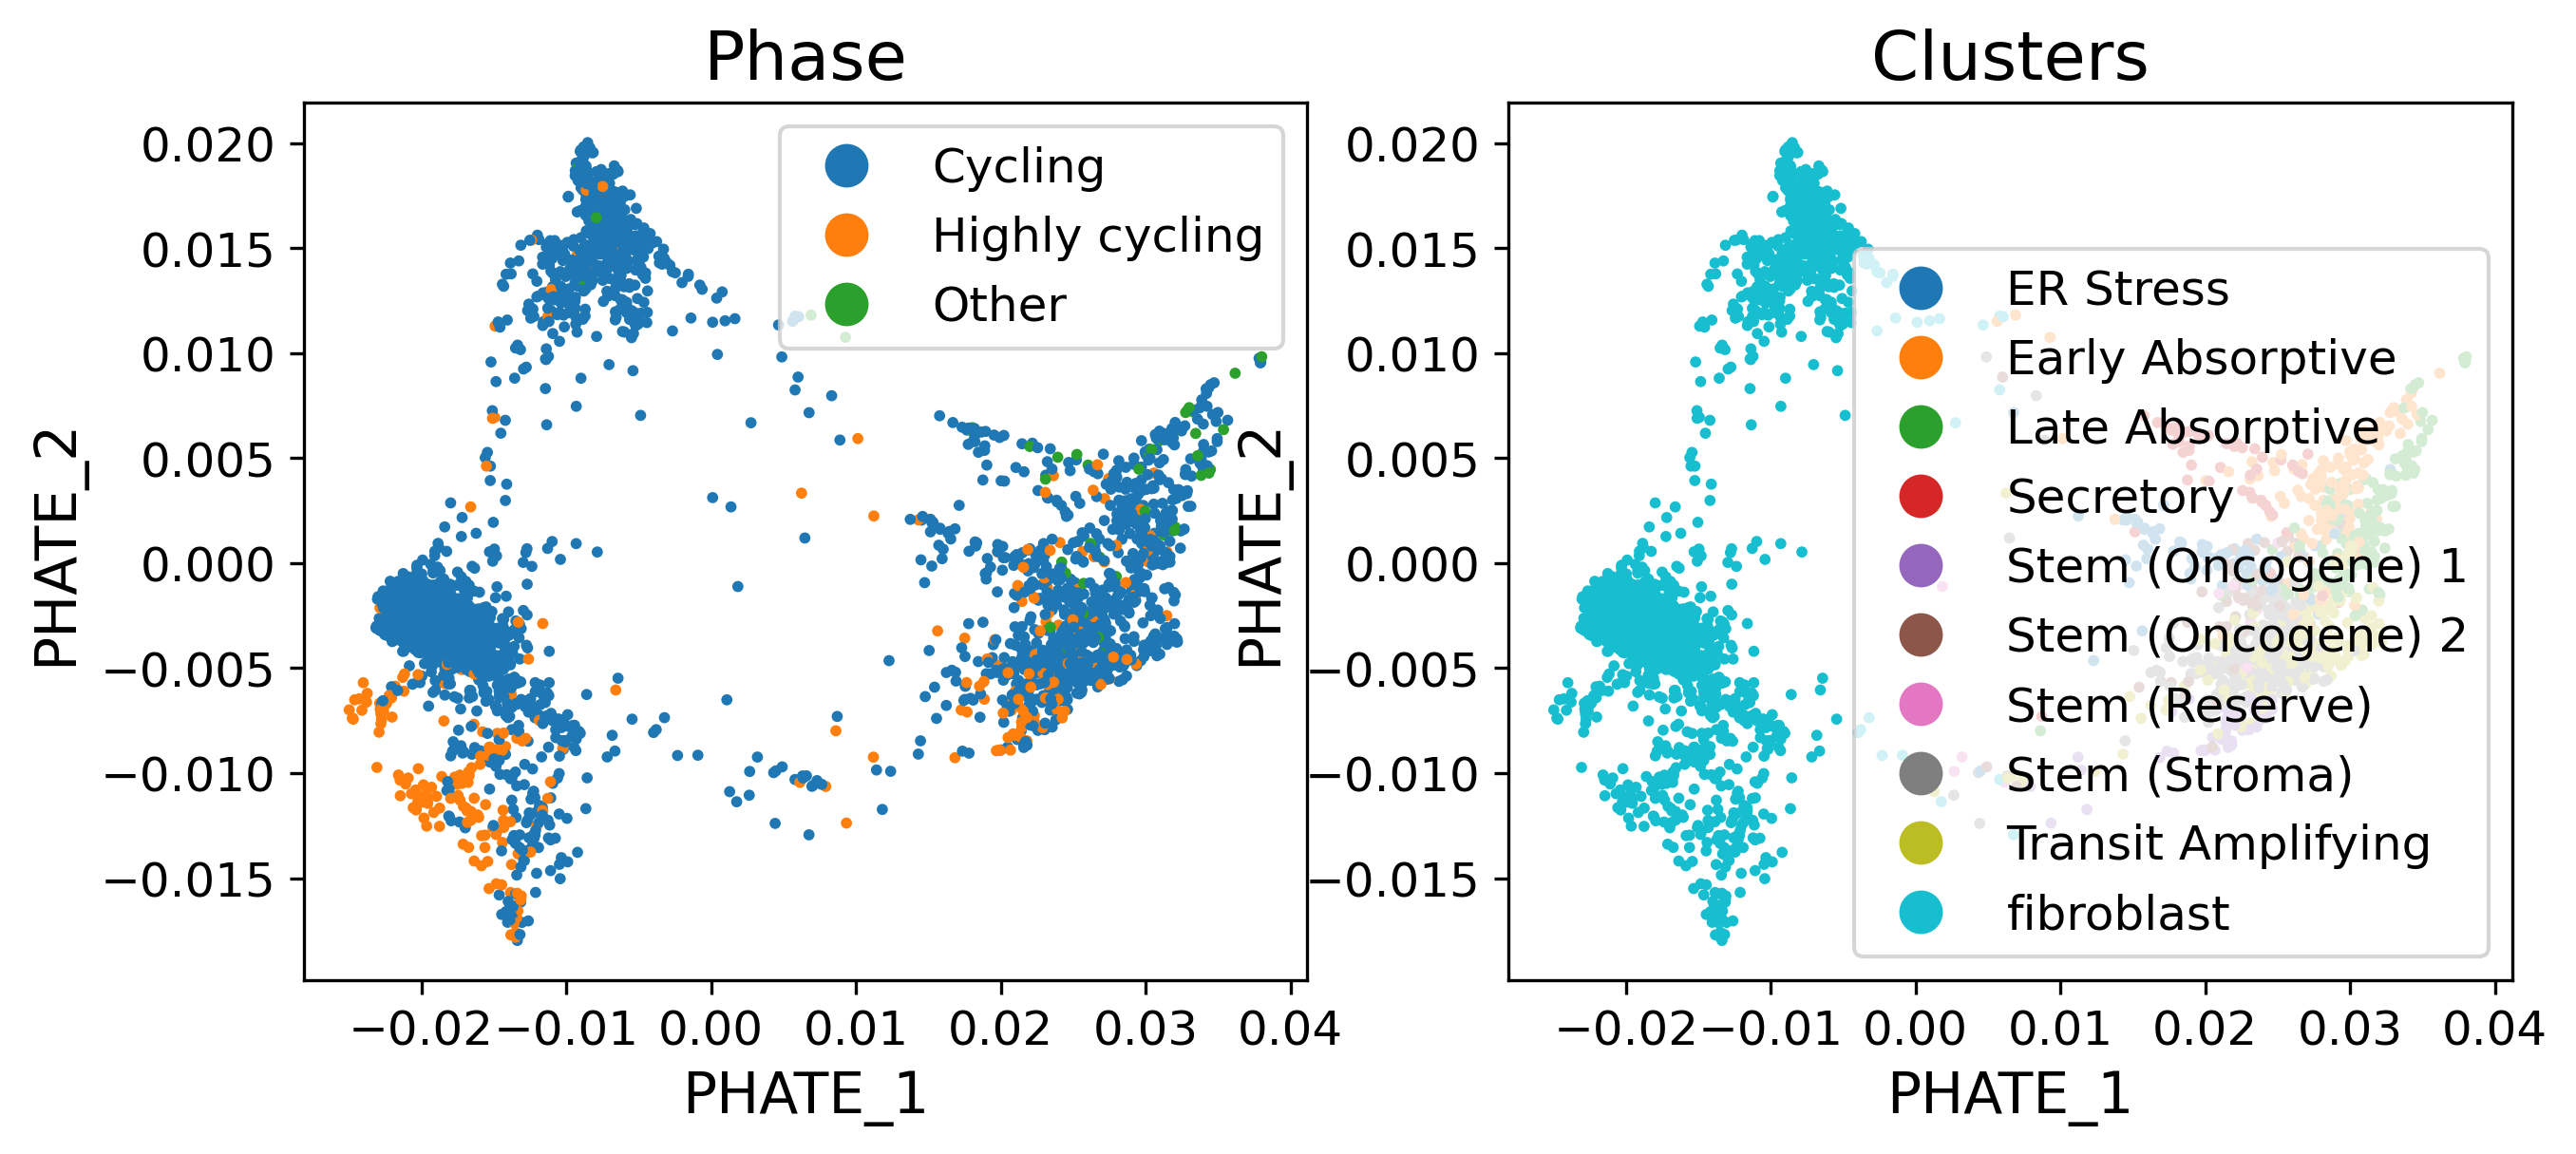

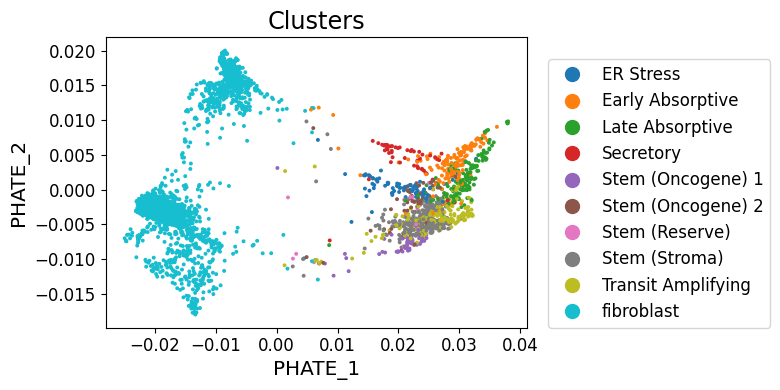

In [9]:
print(dRnaSeq.obsm)#No DimRed were ported over
#Add phate dims and view
dRnaSeq.obsm["X_PHATE"] = dPHATEcoord
del dPHATEcoord

fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300); ax=ax.flatten()
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.Phase, figsize=(4.8,3),
    title=f"Phase", ax=ax[0])
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.finalPOPS, figsize=(4.8,3),
    title=f"Clusters", ax=ax[1])

scprep.plot.scatter2d(
    dRnaSeq.obsm["X_PHATE"], 
    c=dRnaSeq.obs.finalPOPS, 
    title=f"Clusters", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8,4), dpi=480)

print(f"Before filtering we have {len(dRnaSeq.var_names)} genes")
scanpy.pp.filter_genes(dRnaSeq, min_cells=4, inplace=True)
print(f"After filtering genes expressed in fewer than 4 cells we have {len(dRnaSeq.var_names)}")

dRnaSeq

### Process data to human
Convert SEQ data to HGNC symbols

In [10]:
from biomart import BiomartServer

mart = BiomartServer("http://www.ensembl.org/biomart").datasets["mmusculus_gene_ensembl"]
# mart.show_attributes()
# for i in mart.show_attributes_by_page():
#     print(i)

response = mart.search({"attributes":["external_gene_name",
            "hsapiens_homolog_associated_gene_name"]})

mouse2human = []
for line in response.raw.data.decode("utf-8").splitlines():
    line = line.split("\t")
    if len(line[0]) > 0: #Only get gene symbols with ENSP ID
        mouse2human.append(line)
mouse2human = pd.DataFrame(mouse2human, 
                columns=["mgi_symbol","hgnc_symbol"]
                ).drop_duplicates() 
mouse2human = mouse2human.set_index("mgi_symbol"
                ).to_dict(
                    #Transform DF into a dictionary but first set index
                )["hgnc_symbol"]#Nested dict, so get first (and only item)


In [11]:
dSEQmd = dRnaSeq.obs
dRnaSeq = dRnaSeq.to_df(layer="logcounts").rename(columns=mouse2human).drop(
            columns=[""])
#After conversion some columns get duplicated. Group by them and average their gene expression
dRnaSeq = dRnaSeq.groupby(by=dRnaSeq.columns, axis=1).mean()
dRnaSeq

,0610010F05Rik,1110008P14Rik,1110012L19Rik,1110051M20Rik,1300017J02Rik,1500009C09Rik,1700007K13Rik,1700012D14Rik,1700013F07Rik,1700015F17Rik,...,ZZEF1,ZZZ3,Zbed5,Zfp91.1,Zkscan7.1,Znrd1,Znrd1as,n-R5-8s1,pEGFP,partDsRedE
WT__AAACCCACAGCTTCCT-1,0.0,1.050319,0.000000,0.000000,0.0,0.0,0.0,0.657148,0.0,0.0,...,0.657148,0.657148,0.000000,0.000000,0.0,1.050319,0.657148,0.0,0.0,0.657148
WT__AAACCCAGTTCGAGCC-1,0.0,0.498218,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.829238,0.498218,0.000000,0.0,1.077511,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGAAGGATG-1,0.0,1.222830,0.000000,0.469502,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGGAAAGGT-1,0.0,1.006978,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,1.006978,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__AAACGAAAGTTAACGA-1,0.0,1.497693,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.221506,0.000000,0.000000,0.221506,0.0,0.556103,0.221506,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.695505,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGGTTTCCGTAGTA-1,0.0,0.494771,0.000000,0.494771,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,1.071710,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.494771
WT__TTTGTTGTCGCTTGAA-1,0.0,0.461624,0.461624,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
WT__TTTGTTGTCTGAATCG-1,0.0,1.184048,0.882624,0.249549,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.882624,0.000000,0.0,0.0,0.000000


### Pre-processing: MAGIC

Use MAGIC with all genes to denoise, smooth and inpute missing values.
Return only genes in KG.

In [12]:
magic_op = magic.MAGIC(
    knn=5, # knn_max set to 3*knn by default
    knn_dist="euclidean",
    decay=1, t=3, n_pca=100, random_state=12,
    n_jobs=-2 #All but one
                        )

dMagicRnaSeq = magic_op.fit_transform(
    X = dRnaSeq,
    genes = dRnaSeq.columns[dRnaSeq.columns.isin(entityIDS.values())]
)
del magic_op,dRnaSeq
dMagicRnaSeq

Calculating MAGIC...
  Running MAGIC on 3698 cells and 13750 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.68 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.53 seconds.
    Calculating affinities...
    Calculated affinities in 0.47 seconds.
  Calculated graph and diffusion operator in 2.85 seconds.
  Calculating imputation...
  Calculated imputation in 0.01 seconds.
Calculated MAGIC in 3.07 seconds.


,ACVR1,ACVR1B,ACVR2A,ACVR2B,ACVRL1,AMH,AMHR2,AR,BAMBI,BMP2,...,WNT16,WNT2,WNT2B,WNT4,WNT5A,WNT5B,WNT6,WNT7A,WNT7B,WNT9A
WT__AAACCCACAGCTTCCT-1,0.131976,0.081673,0.049884,0.006515,0.009460,0.000616,0.000441,0.074418,0.273059,0.000044,...,0.020018,0.006698,0.002012,1.350994,0.118889,0.086329,0.001611,0.000080,0.001189,0.003603
WT__AAACCCAGTTCGAGCC-1,0.137324,0.079288,0.054080,0.011059,0.016255,0.000047,0.000235,0.046338,0.196842,0.000000,...,0.018380,0.006134,0.001122,1.377690,0.168283,0.074230,0.001645,0.000112,0.000071,0.001999
WT__AAACGAAAGAAGGATG-1,0.120973,0.099487,0.037851,0.005322,0.012983,0.000230,0.000800,0.025959,0.247099,0.001563,...,0.032791,0.014108,0.000803,1.410074,0.153546,0.066795,0.001096,0.000034,0.000264,0.010773
WT__AAACGAAAGGAAAGGT-1,0.033550,0.062326,0.069992,0.013247,0.013083,0.000000,0.001725,0.000000,0.001492,0.391724,...,0.000000,0.000000,0.000000,0.133904,0.000000,0.000000,0.000012,0.004001,0.026078,0.000675
WT__AAACGAAAGTTAACGA-1,0.097737,0.036481,0.043880,0.016335,0.000179,0.000016,0.000330,0.000018,0.010690,0.087978,...,0.000088,0.000485,0.000000,0.050542,0.000547,0.000318,0.000231,0.026103,0.135859,0.001077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.072829,0.076888,0.084281,0.088401,0.000422,0.000000,0.000000,0.001468,0.000489,0.087285,...,0.000013,0.000006,0.000000,0.019581,0.000774,0.000372,0.000006,0.024542,0.125214,0.001002
WT__TTTGGTTTCCGTAGTA-1,0.154212,0.119778,0.034443,0.003957,0.003030,0.000234,0.001035,0.041723,0.233552,0.000480,...,0.034568,0.005783,0.001245,1.669304,0.136010,0.082518,0.000680,0.000005,0.000231,0.002954
WT__TTTGTTGTCGCTTGAA-1,0.058815,0.045155,0.064709,0.022273,0.004514,0.000000,0.007486,0.000167,0.006723,0.164418,...,0.000000,0.000000,0.000000,0.063703,0.001944,0.000160,0.000912,0.010024,0.059745,0.002059
WT__TTTGTTGTCTGAATCG-1,0.139526,0.050981,0.041564,0.010275,0.239226,0.000158,0.000584,0.195817,0.172450,0.023575,...,0.000266,0.002344,0.000000,0.229349,0.128302,0.024434,0.000964,0.000137,0.004162,0.000640


### Scale MAGIC normalised data

In [13]:
#Cell-scalled GEX:
dScalRnaSeq = dMagicRnaSeq.div(dMagicRnaSeq.sum(axis=1), axis=0)
dScalRnaSeq

,ACVR1,ACVR1B,ACVR2A,ACVR2B,ACVRL1,AMH,AMHR2,AR,BAMBI,BMP2,...,WNT16,WNT2,WNT2B,WNT4,WNT5A,WNT5B,WNT6,WNT7A,WNT7B,WNT9A
WT__AAACCCACAGCTTCCT-1,0.008230,0.005093,0.003111,0.000406,0.000590,0.000038,0.000028,0.004641,0.017027,0.000003,...,0.001248,4.176965e-04,0.000125,0.084246,0.007414,0.005383,1.004742e-04,4.977593e-06,0.000074,0.000225
WT__AAACCCAGTTCGAGCC-1,0.008639,0.004988,0.003402,0.000696,0.001023,0.000003,0.000015,0.002915,0.012383,0.000000,...,0.001156,3.858846e-04,0.000071,0.086671,0.010587,0.004670,1.034813e-04,7.025098e-06,0.000004,0.000126
WT__AAACGAAAGAAGGATG-1,0.007653,0.006294,0.002395,0.000337,0.000821,0.000015,0.000051,0.001642,0.015632,0.000099,...,0.002074,8.924997e-04,0.000051,0.089203,0.009714,0.004226,6.934263e-05,2.164130e-06,0.000017,0.000682
WT__AAACGAAAGGAAAGGT-1,0.003299,0.006129,0.006883,0.001303,0.001287,0.000000,0.000170,0.000000,0.000147,0.038522,...,0.000000,0.000000e+00,0.000000,0.013168,0.000000,0.000000,1.149784e-06,3.934925e-04,0.002565,0.000066
WT__AAACGAAAGTTAACGA-1,0.008032,0.002998,0.003606,0.001343,0.000015,0.000001,0.000027,0.000002,0.000879,0.007230,...,0.000007,3.984258e-05,0.000000,0.004154,0.000045,0.000026,1.895977e-05,2.145264e-03,0.011165,0.000088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.008894,0.009390,0.010293,0.010796,0.000052,0.000000,0.000000,0.000179,0.000060,0.010660,...,0.000002,7.352826e-07,0.000000,0.002391,0.000094,0.000045,7.478716e-07,2.997160e-03,0.015292,0.000122
WT__TTTGGTTTCCGTAGTA-1,0.008710,0.006765,0.001945,0.000224,0.000171,0.000013,0.000058,0.002356,0.013191,0.000027,...,0.001952,3.266360e-04,0.000070,0.094281,0.007682,0.004661,3.837961e-05,3.019646e-07,0.000013,0.000167
WT__TTTGTTGTCGCTTGAA-1,0.005227,0.004013,0.005750,0.001979,0.000401,0.000000,0.000665,0.000015,0.000597,0.014611,...,0.000000,0.000000e+00,0.000000,0.005661,0.000173,0.000014,8.106235e-05,8.907671e-04,0.005309,0.000183
WT__TTTGTTGTCTGAATCG-1,0.009599,0.003507,0.002860,0.000707,0.016459,0.000011,0.000040,0.013472,0.011864,0.001622,...,0.000018,1.612804e-04,0.000000,0.015779,0.008827,0.001681,6.630320e-05,9.423155e-06,0.000286,0.000044


### Match genes in KG and scRNA-seq

In [14]:
dScalRnaSeq = dScalRnaSeq.reindex(columns=list(entityIDS.values()), fill_value=float("0"))
dScalRnaSeq

,ACVR1,ACVR1B,ACVR1C,ACVR2A,ACVR2B,ACVRL1,AMH,AMHR2,AR,BAMBI,...,WNT7B,WNT8A,WNT8B,WNT9A,WNT9B,p-\S*S473\S*-AKT1,p-\S*T308\S*-AKT1,p-\S+-MAPK(3|1)\s+,p-\S+-SMAD(1|5|9),p-\S+-SMAD(2|3)
WT__AAACCCACAGCTTCCT-1,0.008230,0.005093,0.0,0.003111,0.000406,0.000590,0.000038,0.000028,0.004641,0.017027,...,0.000074,0.0,0.0,0.000225,0.0,0.0,0.0,0.0,0.0,0.0
WT__AAACCCAGTTCGAGCC-1,0.008639,0.004988,0.0,0.003402,0.000696,0.001023,0.000003,0.000015,0.002915,0.012383,...,0.000004,0.0,0.0,0.000126,0.0,0.0,0.0,0.0,0.0,0.0
WT__AAACGAAAGAAGGATG-1,0.007653,0.006294,0.0,0.002395,0.000337,0.000821,0.000015,0.000051,0.001642,0.015632,...,0.000017,0.0,0.0,0.000682,0.0,0.0,0.0,0.0,0.0,0.0
WT__AAACGAAAGGAAAGGT-1,0.003299,0.006129,0.0,0.006883,0.001303,0.001287,0.000000,0.000170,0.000000,0.000147,...,0.002565,0.0,0.0,0.000066,0.0,0.0,0.0,0.0,0.0,0.0
WT__AAACGAAAGTTAACGA-1,0.008032,0.002998,0.0,0.003606,0.001343,0.000015,0.000001,0.000027,0.000002,0.000879,...,0.011165,0.0,0.0,0.000088,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.008894,0.009390,0.0,0.010293,0.010796,0.000052,0.000000,0.000000,0.000179,0.000060,...,0.015292,0.0,0.0,0.000122,0.0,0.0,0.0,0.0,0.0,0.0
WT__TTTGGTTTCCGTAGTA-1,0.008710,0.006765,0.0,0.001945,0.000224,0.000171,0.000013,0.000058,0.002356,0.013191,...,0.000013,0.0,0.0,0.000167,0.0,0.0,0.0,0.0,0.0,0.0
WT__TTTGTTGTCGCTTGAA-1,0.005227,0.004013,0.0,0.005750,0.001979,0.000401,0.000000,0.000665,0.000015,0.000597,...,0.005309,0.0,0.0,0.000183,0.0,0.0,0.0,0.0,0.0,0.0
WT__TTTGTTGTCTGAATCG-1,0.009599,0.003507,0.0,0.002860,0.000707,0.016459,0.000011,0.000040,0.013472,0.011864,...,0.000286,0.0,0.0,0.000044,0.0,0.0,0.0,0.0,0.0,0.0


## Load CyTOF data

In [15]:
dCyt = pd.read_csv(f"{data_dir}/Omics/dWTfib_cytof.txt",sep="\t").filter(regex = "^\d+|^file_identifier")
dCyt

,89Y_pHH3_S28,111Cd_CD44_v2,113In_CEACAM1_CD66a_v2,114Cd_CK18_v2,115In_Pan-CK_v5,122Te_Barcode,123Te_Barcode,124Te_Barcode,125Te_Barcode,126Te_Barcode,...,172Yb_pS6_S235_236_v2,173Yb_PDPN_v2,174Yb_RFP,175Lu_Vimentin,176Yb_Cyclin_B1_2_v2,191Ir_DNA_1,193Ir_DNA_2,194Pt_Cisplatin,209Bi_CK18,file_identifier
0,0.000000,1990.980957,18.211060,2928.800781,1973.129028,771.304932,14.819576,563.619202,699.982117,25.099878,...,11688.049805,504.713531,29.877979,4299.611816,200.047882,63777.085938,121983.914062,18089.599609,1510.892578,Pro_WTfib_fib
1,0.000000,825.002075,1.621021,8.841931,45.782940,400.186676,53.228016,331.107513,406.801514,51.104706,...,5725.374512,2165.157471,213.488480,1535.135986,132.647461,18011.433594,32582.429688,1185.106079,0.000000,Pro_WTfib_fib
2,0.545875,23.752832,2.710696,75.029808,224.630737,6442.486816,119.965919,6082.173828,6060.972168,700.094177,...,0.000000,515.552185,825.009094,0.000000,37.127651,36602.984375,72815.867188,14817.324219,43.982540,Pro_WTfib_fib
3,1.687439,993.330872,4.313036,18.532772,19.012230,179.756882,25.230639,174.673813,156.020660,21.305735,...,31.062332,453.606934,234.555603,32.569691,10.049050,25414.136719,47861.183594,1220.816040,1.686805,Pro_WTfib_fib
4,0.000000,55.538124,1.648003,29.172148,8.418515,384.167419,13.115532,243.553711,243.389740,24.149267,...,21.605457,161.520538,49.635128,0.000000,0.000000,13607.113281,23980.585938,1471.665405,0.000000,Pro_WTfib_fib
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23944,0.575287,0.000000,29.917067,1177.036377,1878.979126,18780.707031,347.416901,17428.015625,18221.324219,1969.474243,...,5.057156,105.512360,56.930191,0.000000,128.641403,16511.298828,31044.115234,7563.200195,516.480652,Pro_WTfib_epi
23945,8.733110,51.412457,316.347076,2758.709229,1413.775513,17464.484375,319.504669,16184.413086,17701.402344,1702.833252,...,2.509986,6.395815,48.340462,3.997385,336.654144,15596.995117,32046.751953,1247.258301,2554.626221,Pro_WTfib_epi
23946,0.000000,32.676712,47.151875,218.732193,142.701355,4548.200684,99.833855,4417.928711,4601.003906,413.944672,...,0.000000,0.000000,67.100281,0.000000,836.829224,12291.399414,25326.033203,1548.010376,302.388184,Pro_WTfib_epi
23947,2.054595,5.049978,3.555531,236.509842,129.904480,41.158947,3.220307,73.682106,52.007206,9.751757,...,0.000000,0.000000,15.115691,0.000000,27.275177,2755.387939,6044.491699,109.323814,568.037659,Pro_WTfib_epi


In [16]:
mdCYT = dCyt["file_identifier"]
mdCYT

0        Pro_WTfib_fib
1        Pro_WTfib_fib
2        Pro_WTfib_fib
3        Pro_WTfib_fib
4        Pro_WTfib_fib
             ...      
23944    Pro_WTfib_epi
23945    Pro_WTfib_epi
23946    Pro_WTfib_epi
23947    Pro_WTfib_epi
23948    Pro_WTfib_epi
Name: file_identifier, Length: 23949, dtype: object

In [17]:
#Dict of regex used to get the PTMs
PTMdict = {
    '89Y_pHH3_S28':"H3F3A",
    '141Pr_pPDK1_S241_v4':"PDK1",
    '142Nd_cCaspase_3_D175_v3':"CASP3",
    '144Nd_pMEK1_2_S221_v3':"p-\S*S\S*-MAP2K(1|2)\s+",
    '146Nd_pMKK4_SEK1_S257_v3':"p-\S*S257\S*-MAP2K4",
    '147Sm_pBTK_Y511_v4':"BTK",
    '148Nd_pSRC_Y418_v5':"p-\S*Y41\S*-SRC",
    '149Sm_p4EBP1_T37_T46_v2':"p-\S*T37,T46\S*-EIF4EBP1",
    '150Nd_pRB_S807_S811_v3':"p-\S*S8\S*-RB1",
    '152Sm_pAKT_T308_v7':"p-\S*T308\S*-AKT1",
    '153Eu_pCREB_S133_v8':"p-\S*S473\S*-AKT1",
    '154Sm_pSMAD1_5_9_v5':"p-\S*S133\S*-CREB1",
    '155Gd_pAKT_S473_v6':"p-\S+-SMAD(1|5|9)",
    '156Gd_pNF-kB_p65_S529_v4':"RELA",
    '157Gd_pMKK3_MKK6_S189_207_v3':"p-\S*S\S*-MAP2K(3|6)", 
    '158Gd_pP38_MAPK_T180_Y182_v3':"p-\S*T180,Y182\S*-MAPK(14|11|13|12)",
    '159Tb_pMAPKAPK2_T334_v2':"p-\S*T334\S*-MAPKAPK2", 
    '160Gd_pAMPKa_T172_v3':"p-\S*T1\S*PRKAA1", 
    '161Dy_pBAD_S112_v4':"BAD",
    '163Dy_pP90RSK_T359_Hu_v5':"p-\S*T359\S*-RPS6KA1",
    '166Er_pGSK-3b_S9_v2':"GSK3B",
    '167Er_pERK1_2_T202_Y204_v2':"p-\S+-MAPK(3|1)\s+", 
    '168Er_pSMAD2_3_v4':"p-\S+-SMAD(2|3)", 
    '169Tm_pSTAT3_Y705':"p-\S*Y705\S*-STAT3",
    '170Er_pMEK1_2_S221_v2':"p-\S*S\S*-MAP2K(1|2)\s+",
    '172Yb_pS6_S235_236_v2':"p-\S+-RPS6\s+"
}
len(PTMdict)

26

In [18]:
dCyt = dCyt[PTMdict.keys()].rename(columns=PTMdict).apply(lambda x: np.arcsinh(x/5)).drop_duplicates()
dCyt #change col names, arcsinh , and remove duplicated rows

,H3F3A,PDK1,CASP3,p-\S*S\S*-MAP2K(1|2)\s+,p-\S*S257\S*-MAP2K4,BTK,p-\S*Y41\S*-SRC,"p-\S*T37,T46\S*-EIF4EBP1",p-\S*S8\S*-RB1,p-\S*T308\S*-AKT1,...,p-\S*T334\S*-MAPKAPK2,p-\S*T1\S*PRKAA1,BAD,p-\S*T359\S*-RPS6KA1,GSK3B,p-\S+-MAPK(3|1)\s+,p-\S+-SMAD(2|3),p-\S*Y705\S*-STAT3,p-\S*S\S*-MAP2K(1|2)\s+,p-\S+-RPS6\s+
0,0.000000,5.308367,1.207209,0.364939,3.471293,2.481343,2.930672,6.060546,5.464390,4.557720,...,0.958691,3.198869,3.600043,3.224514,7.003456,4.007740,3.699905,3.752423,2.477639,8.450032
1,0.000000,5.197078,2.685628,1.081096,4.003188,3.153990,2.793700,5.649097,4.899978,4.362016,...,1.328496,3.517160,4.023858,4.218800,6.007657,5.462488,4.871222,3.483333,2.516954,7.736373
2,0.108959,5.106033,0.498383,0.000000,3.626036,3.773435,1.985738,2.389460,3.602301,1.947978,...,2.070560,1.874575,0.692908,4.049660,2.898702,4.240035,5.916800,0.000000,0.000000,0.000000
3,0.331389,4.384547,0.921120,0.264727,2.396816,1.402873,0.961453,5.336830,2.106047,1.941019,...,0.000000,2.390079,3.570526,2.708081,3.918168,4.937258,1.680586,2.680297,1.548809,2.526121
4,0.000000,2.741168,2.353907,1.331160,1.818715,2.488983,0.452464,0.299066,0.000000,0.847226,...,0.000000,0.000000,0.000000,1.625405,3.420640,1.861912,0.000000,0.000000,0.000000,2.169783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23944,0.114805,4.799236,1.059359,0.321874,0.213282,1.145122,0.800867,0.539813,1.573258,0.000000,...,1.214807,1.406020,1.793720,1.653494,2.477897,2.749167,3.034466,2.046051,0.000000,0.889434
23945,1.324221,4.843259,0.840317,0.601357,0.505130,2.264306,0.837263,1.171826,1.080459,0.106895,...,0.968452,1.325617,0.724991,1.744503,2.732925,0.224927,1.566522,2.037508,1.056488,0.482997
23946,0.000000,3.925135,0.717585,0.807214,1.442987,1.915841,1.487728,1.328570,2.635072,1.509679,...,1.577551,2.110289,2.350023,2.010160,0.743835,2.640179,3.625772,2.677492,1.646797,0.000000
23947,0.400154,1.040477,0.000000,0.363667,0.460964,0.114858,0.491262,0.000000,0.000000,0.000000,...,1.236349,0.000000,0.279336,0.000000,0.000000,1.332116,3.825506,0.000000,0.000000,0.000000


In [19]:
mdCYT = mdCYT.loc[mdCYT.index.isin(dCyt.index)]
mdCYT

0        Pro_WTfib_fib
1        Pro_WTfib_fib
2        Pro_WTfib_fib
3        Pro_WTfib_fib
4        Pro_WTfib_fib
             ...      
23944    Pro_WTfib_epi
23945    Pro_WTfib_epi
23946    Pro_WTfib_epi
23947    Pro_WTfib_epi
23948    Pro_WTfib_epi
Name: file_identifier, Length: 23145, dtype: object

In [20]:
# data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(dCyt) 

In [21]:
# scprep.plot.scatter2d(
#     data_phate, c=mdCYT,
#     title="PHATE of arcsinh+MAGIC cytof cells (col=typegate)", 
#     shuffle=True,ticks=None,
#     legend_loc=(1.05, 0))
# scprep.plot.scatter2d(
#     data_phate, c=dCyt["CASP3"],
#     title="PHATE of arcsinh+MAGIC cytof cells (col=Caspase)", 
#     shuffle=True,ticks=None,
#     legend_loc=(1.05, 0))
# scprep.plot.scatter2d(
#     data_phate, c=dCyt["p-\S*S8\S*-RB1"],
#     title="PHATE of arcsinh+MAGIC cytof cells (col=pRB1)", 
#     shuffle=True,ticks=None,
#     legend_loc=(1.05, 0))

### Pre-processing: MAGIC

In [22]:
len(dCyt.columns[dCyt.columns.isin(entityIDS.values())]) #Sanity check, should still be the same num of cols

7

In [23]:
magic_op = magic.MAGIC(
    knn=5, # knn_max set to 3*knn by default
    knn_dist="euclidean",
    decay=1, t=3, n_pca=100, random_state=12,
    n_jobs=-2 #All but one
                        )

dMagicCyt = magic_op.fit_transform(
    X = dCyt
)
del magic_op
dMagicCyt

Calculating MAGIC...
  Running MAGIC on 23145 cells and 26 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 12.51 seconds.
    Calculating affinities...
    Calculated affinities in 12.65 seconds.
  Calculated graph and diffusion operator in 25.20 seconds.
  Calculating imputation...
  Calculated imputation in 0.04 seconds.
Calculated MAGIC in 25.24 seconds.


,H3F3A,PDK1,CASP3,p-\S*S\S*-MAP2K(1|2)\s+,p-\S*S257\S*-MAP2K4,BTK,p-\S*Y41\S*-SRC,"p-\S*T37,T46\S*-EIF4EBP1",p-\S*S8\S*-RB1,p-\S*T308\S*-AKT1,...,p-\S*T334\S*-MAPKAPK2,p-\S*T1\S*PRKAA1,BAD,p-\S*T359\S*-RPS6KA1,GSK3B,p-\S+-MAPK(3|1)\s+,p-\S+-SMAD(2|3),p-\S*Y705\S*-STAT3,p-\S*S\S*-MAP2K(1|2)\s+,p-\S+-RPS6\s+
0,0.969921,5.028474,1.310884,0.723074,4.063050,2.784834,2.065293,5.519432,4.549547,3.494137,...,0.962294,3.661452,3.899616,3.657536,5.449692,4.548958,3.826031,2.623868,2.078775,6.465075
1,0.989181,5.075293,1.348455,0.754114,4.133732,2.853634,2.075914,5.523423,4.581439,3.521848,...,0.967380,3.704134,3.955915,3.696468,5.451652,4.659614,3.940166,2.655060,2.120985,6.462107
2,0.360074,4.005344,1.028126,0.699715,3.220904,3.047424,1.147961,1.603776,2.664188,0.964845,...,1.812618,1.676871,0.906135,3.570309,2.665144,4.438853,4.096544,0.962103,0.536227,0.512113
3,0.476188,4.107901,1.319299,0.575874,2.429595,2.284370,1.385351,3.086521,2.557498,1.735075,...,1.488912,2.515161,2.260774,2.400010,3.665524,3.489248,3.543021,2.476036,1.359796,3.203275
4,0.145084,2.025643,1.399915,0.495646,1.136082,1.698516,0.486995,0.495354,0.491569,0.325917,...,0.540326,0.585278,0.399051,0.995234,2.377341,1.657132,1.338613,0.430875,0.308982,1.265609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23944,0.429739,3.946099,0.930401,0.409931,0.794512,1.586073,0.663343,1.165265,1.807204,0.602622,...,1.389400,1.643086,1.196790,1.245188,2.328783,2.571173,3.131588,2.076410,0.186524,0.475455
23945,0.612318,4.237323,0.788834,0.406859,0.777315,1.752572,0.685648,1.222818,1.535311,0.576977,...,1.232210,1.563273,1.000133,1.339332,2.291807,0.604379,1.884838,1.816584,0.634510,0.368100
23946,0.357192,3.646550,1.037187,0.575371,1.318566,2.038212,1.048415,1.511276,2.097640,1.062217,...,1.696508,1.994437,1.565686,1.570726,0.844546,2.526911,3.629296,2.384323,1.332222,0.328552
23947,0.122947,0.687698,0.472122,0.219180,0.456217,0.694442,0.294054,0.210735,0.210608,0.123670,...,0.466107,0.313309,0.224585,0.302848,0.135704,1.394115,3.310451,0.225146,0.173862,0.088843


In [24]:
#Need to average expr of duplicated columns
dMagicCyt = dMagicCyt.groupby(by=dMagicCyt.columns, axis=1).mean()
dMagicCyt.shape

(23145, 25)

In [25]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(dMagicCyt) 

Calculating PHATE...
  Running PHATE on 23145 observations and 25 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 6.35 seconds.
    Calculating affinities...
    Calculated affinities in 0.16 seconds.
  Calculated graph and diffusion operator in 6.53 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.08 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.49 seconds.
  Calculated landmark operator in 7.10 seconds.
  Calculating optimal t...
    Automatically selected t = 55
  Calculated optimal t in 1.11 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.63 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.67 seconds.
Calculated PHATE in 20.05 seconds.


<AxesSubplot: title={'center': 'PHATE of arcsinh+MAGIC cytof cells (col=pRB1)'}>

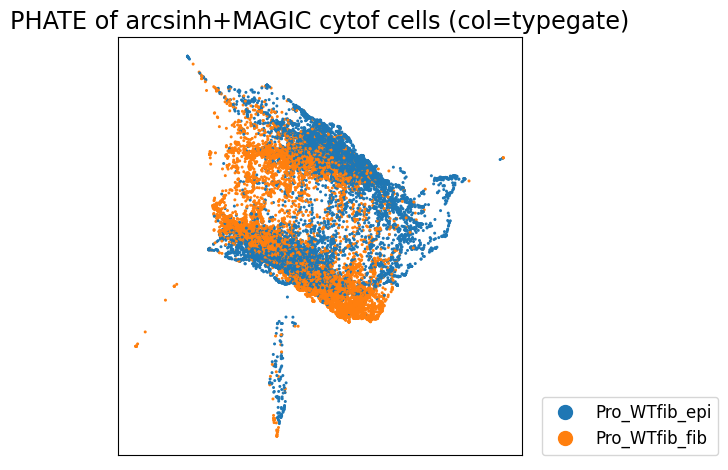

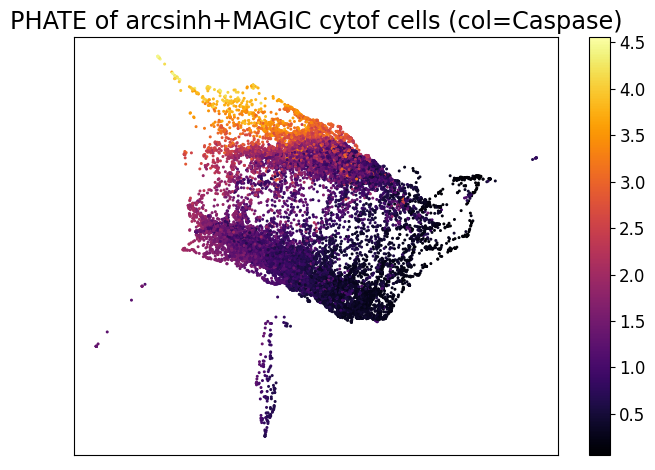

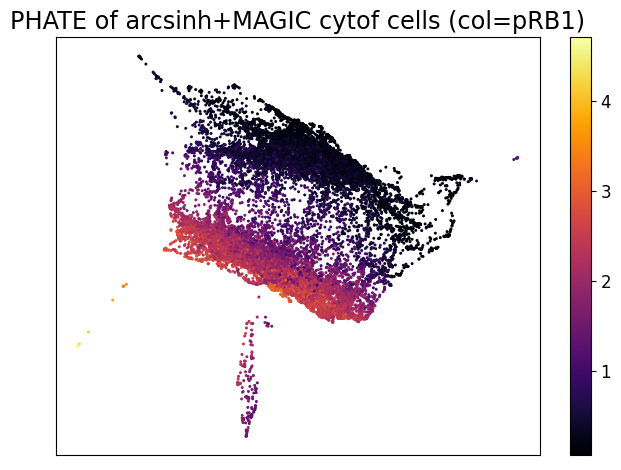

In [26]:
scprep.plot.scatter2d(
    data_phate, c=mdCYT,
    title="PHATE of arcsinh+MAGIC cytof cells (col=typegate)", 
    shuffle=True,ticks=None,
    legend_loc=(1.05, 0))
scprep.plot.scatter2d(
    data_phate, c=dMagicCyt["CASP3"],
    title="PHATE of arcsinh+MAGIC cytof cells (col=Caspase)", 
    shuffle=True,ticks=None,
    legend_loc=(1.05, 0))
scprep.plot.scatter2d(
    data_phate, c=dMagicCyt["p-\S*S8\S*-RB1"],
    title="PHATE of arcsinh+MAGIC cytof cells (col=pRB1)", 
    shuffle=True,ticks=None,
    legend_loc=(1.05, 0))

### Scale normalised data


In [27]:
dScalCyt = dMagicCyt.div(dMagicCyt.sum(axis=1), axis=0)
del dCyt
dScalCyt

,BAD,BTK,CASP3,GSK3B,H3F3A,PDK1,RELA,p-\S*S133\S*-CREB1,p-\S*S257\S*-MAP2K4,p-\S*S473\S*-AKT1,...,p-\S*T308\S*-AKT1,p-\S*T334\S*-MAPKAPK2,p-\S*T359\S*-RPS6KA1,"p-\S*T37,T46\S*-EIF4EBP1",p-\S*Y41\S*-SRC,p-\S*Y705\S*-STAT3,p-\S+-MAPK(3|1)\s+,p-\S+-RPS6\s+,p-\S+-SMAD(1|5|9),p-\S+-SMAD(2|3)
0,0.045320,0.032364,0.015235,0.063334,0.011272,0.058439,0.042414,0.021256,0.047219,0.056743,...,0.040607,0.011183,0.042506,0.064144,0.024002,0.030493,0.052866,0.075134,0.030368,0.044464
1,0.045387,0.032740,0.015471,0.062548,0.011349,0.058230,0.042708,0.021360,0.047427,0.056214,...,0.040407,0.011099,0.042410,0.063371,0.023817,0.030462,0.053461,0.074141,0.030896,0.045206
2,0.017804,0.059878,0.020201,0.052367,0.007075,0.078700,0.073439,0.011725,0.063287,0.014113,...,0.018958,0.035616,0.070152,0.031512,0.022556,0.018904,0.087218,0.010062,0.012412,0.080492
3,0.038846,0.039251,0.022669,0.062983,0.008182,0.070584,0.048735,0.018364,0.041747,0.038609,...,0.029813,0.025583,0.041238,0.053034,0.023804,0.042545,0.059954,0.055041,0.020481,0.060878
4,0.016943,0.072114,0.059436,0.100935,0.006160,0.086003,0.078850,0.010253,0.048235,0.013171,...,0.013838,0.022941,0.042255,0.021031,0.020676,0.018294,0.070357,0.053734,0.014367,0.056834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23944,0.032381,0.042913,0.025173,0.063008,0.011627,0.106767,0.056945,0.011673,0.021497,0.019593,...,0.016305,0.037592,0.033690,0.031528,0.017948,0.056180,0.069567,0.012864,0.016279,0.084729
23945,0.029342,0.051417,0.023143,0.067237,0.017964,0.124315,0.079658,0.010705,0.022805,0.016327,...,0.016927,0.036151,0.039293,0.035875,0.020116,0.053295,0.017731,0.010799,0.016955,0.055297
23946,0.038069,0.049558,0.025219,0.020535,0.008685,0.088665,0.059580,0.012845,0.032060,0.023681,...,0.025827,0.041250,0.038192,0.036746,0.025492,0.057974,0.061441,0.007989,0.018586,0.088245
23947,0.018273,0.056501,0.038413,0.011041,0.010003,0.055953,0.078397,0.013650,0.037119,0.012049,...,0.010062,0.037924,0.024640,0.017146,0.023925,0.018318,0.113428,0.007229,0.015161,0.269346


### Match genes in KG and scRNA-seq

In [28]:
dScalCyt = dScalCyt.reindex(columns=list(entityIDS.values()), fill_value=float("0"))
dScalCyt

,ACVR1,ACVR1B,ACVR1C,ACVR2A,ACVR2B,ACVRL1,AMH,AMHR2,AR,BAMBI,...,WNT7B,WNT8A,WNT8B,WNT9A,WNT9B,p-\S*S473\S*-AKT1,p-\S*T308\S*-AKT1,p-\S+-MAPK(3|1)\s+,p-\S+-SMAD(1|5|9),p-\S+-SMAD(2|3)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.056743,0.040607,0.052866,0.030368,0.044464
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.056214,0.040407,0.053461,0.030896,0.045206
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.014113,0.018958,0.087218,0.012412,0.080492
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.038609,0.029813,0.059954,0.020481,0.060878
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.013171,0.013838,0.070357,0.014367,0.056834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.019593,0.016305,0.069567,0.016279,0.084729
23945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.016327,0.016927,0.017731,0.016955,0.055297
23946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.023681,0.025827,0.061441,0.018586,0.088245
23947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.012049,0.010062,0.113428,0.015161,0.269346


# Wavelet dictionaries

Compute knn graph based on KGE

In [29]:
knnKGE = sklearn.neighbors.kneighbors_graph(
    dKGEnodes_50, n_neighbors = 5, mode = "connectivity",
    n_jobs = -2
)
print(knnKGE.toarray())
pyG = pygsp.graphs.Graph(W=knnKGE)
pyG

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [30]:
print(pyG.check_weights())
print(pyG.is_connected())
print(pyG.is_directed())

{'has_inf_val': False, 'has_nan_value': False, 'is_not_square': False, 'diag_is_not_zero': False}
False
True


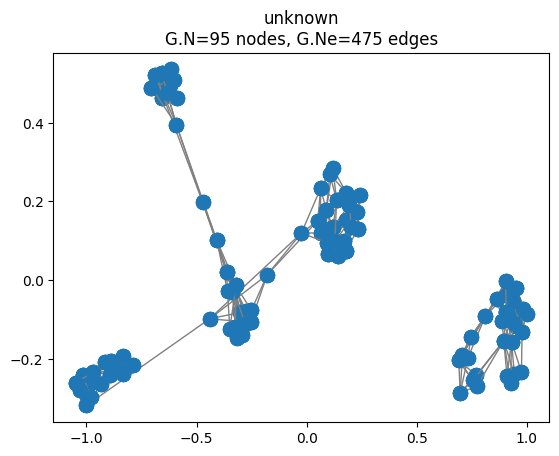

In [31]:
pyG.set_coordinates()
pyG.plot()

In [32]:
wavloc = Localizer(pyG) #Takes only pygsp graphs
wavloc.CalculateWavelets(J=10) #J is the scale param.
wavloc.FlattenAndNormalize()
print(wavloc.FlatWaves.shape)
wavloc.FlatWaves

Calculating Wavelets Using J = 10


100%|██████████| 8/8 [00:00<00:00, 3686.90it/s]


Flattening and Normalizing Wavelets


100%|██████████| 10/10 [00:00<00:00, 1431.80it/s]

(95, 950)


array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.57735027, 0.57735027,
        0.57735027],
       [0.        , 0.        , 0.        , ..., 0.57735027, 0.57735027,
        0.57735027],
       [0.        , 0.        , 0.        , ..., 0.57735027, 0.57735027,
        0.57735027]])

In [33]:
wavloc.wavelets = wavloc.wavelets[1:10]
wavloc.Precomputed = False
wavloc.J = wavloc.J - 1
print("Setting wavelet diagonals to Zero")
for i in range(wavloc.J):
    np.fill_diagonal(wavloc.wavelets[i], 0)
    if np.sum(wavloc.wavelets[i]) == 0:
        print("this is empty")
        print(i)
        print("YOU SHOULD NEVER SEE THIS MESSAGE!")
wavloc.FlattenAndNormalize()
print(wavloc.FlatWaves.shape)
wavloc.FlatWaves

Setting wavelet diagonals to Zero
Flattening and Normalizing Wavelets


  0%|          | 0/9 [00:00<?, ?it/s]/gpfs/ysm/home/fc489/yaleCollab/localization.py:141: RuntimeWarning: invalid value encountered in divide
  A[:,i]=A[:,i]/np.linalg.norm(A[:,i])
100%|██████████| 9/9 [00:00<00:00, 267.50it/s]

(95, 855)


array([[ 0.        , -0.49562035, -0.02680281, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.70710678,  0.70710678],
       [ 0.        ,  0.        ,  0.        , ...,  0.70710678,
         0.        ,  0.70710678],
       [ 0.        ,  0.        ,  0.        , ...,  0.70710678,
         0.70710678,  0.        ]])

In [34]:
wavloc.FlatWaves = wavloc.FlatWaves[:,~np.all(np.isnan(wavloc.FlatWaves), axis=0)] #Any and all do the same

In [35]:
print(wavloc.FlatWaves.shape)
wavloc.FlatWaves

(95, 846)


array([[ 0.        , -0.49562035, -0.02680281, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.70710678,  0.70710678],
       [ 0.        ,  0.        ,  0.        , ...,  0.70710678,
         0.        ,  0.70710678],
       [ 0.        ,  0.        ,  0.        , ...,  0.70710678,
         0.70710678,  0.        ]])

When computing wavelets on multigraphs we get wavelets with NaN entries

In [36]:
pd.DataFrame(wavloc.FlatWaves, index=list(entityIDS.values()))

,0,1,2,3,4,5,6,7,8,9,...,836,837,838,839,840,841,842,843,844,845
ACVR1,0.000000,-0.495620,-0.026803,-0.734968,-0.50750,0.000000,0.000000,0.000000,0.0,-0.038320,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000
ACVR1B,0.000000,0.000000,0.000000,-0.066815,-0.39875,0.000000,0.000000,0.000000,0.0,-0.095800,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000
ACVR1C,0.000000,0.000000,0.000000,0.000000,0.00000,-0.713024,0.000000,-0.330463,0.0,-0.268241,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000
ACVR2A,-0.995037,-0.457496,0.000000,0.000000,-0.47125,-0.064820,0.000000,0.000000,0.0,-0.057480,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000
ACVR2B,-0.099504,-0.076249,-0.026803,-0.668153,0.00000,-0.064820,0.000000,-0.030042,0.0,-0.249081,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p-\S*S473\S*-AKT1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.57735,0.000000,0.000000,0.000000
p-\S*T308\S*-AKT1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.57735,0.00000,0.000000,0.000000,0.000000
p-\S+-MAPK(3|1)\s+,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.063844,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.707107,0.707107
p-\S+-SMAD(1|5|9),0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.063844,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.707107,0.000000,0.707107


# Project data

## CyTOF

In [37]:
#Multiply 2 matrices using the dot product
cyt_projection = np.dot(dScalCyt, wavloc.FlatWaves)
print(cyt_projection.shape) #Shape should be cellsXwavelets
cyt_projection

(23145, 846)


array([[0.        , 0.        , 0.        , ..., 0.05291448, 0.06882302,
        0.05885526],
       [0.        , 0.        , 0.        , ..., 0.05381224, 0.06976793,
        0.05964894],
       [0.        , 0.        , 0.        , ..., 0.06569275, 0.11858863,
        0.07044871],
       ...,
       [0.        , 0.        , 0.        , ..., 0.07554119, 0.10584409,
        0.05658782],
       [0.        , 0.        , 0.        , ..., 0.20117702, 0.27066231,
        0.09092667],
       [0.        , 0.        , 0.        , ..., 0.07422743, 0.11230731,
        0.05845682]])

In [38]:
# #Save to file as compressed npy object
# np.savez_compressed(f"{data_dir}/cell_projection_KGnn3WAV.npz", cell_projection)

In [39]:
# cell_projection = np.load(f"{data_dir}/cell_projection_KGnn3WAV.npz")["arr_0"]#Dict-like struct.Default arr_N keys
# print(cell_projection.shape) #Shape should be cellsXwavelets
# cell_projection

In [40]:
print(np.isnan(np.sum(cyt_projection)))

False


In [41]:
from sklearn.impute import SimpleImputer
cyt_projection = SimpleImputer(strategy="constant").fit_transform(cyt_projection)
print(np.isnan(np.sum(cyt_projection)))

False


In [42]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(cyt_projection) 

Calculating PHATE...
  Running PHATE on 23145 observations and 846 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.60 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.72 seconds.
    Calculating affinities...
    Calculated affinities in 0.14 seconds.
  Calculated graph and diffusion operator in 3.48 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.03 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.33 seconds.
  Calculated landmark operator in 7.85 seconds.
  Calculating optimal t...
    Automatically selected t = 31
  Calculated optimal t in 1.07 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.58 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.80 seconds.
Calculated PHATE in 17.79 seconds.


KeyError: 'p-\\S*S8\\S*-RB1'

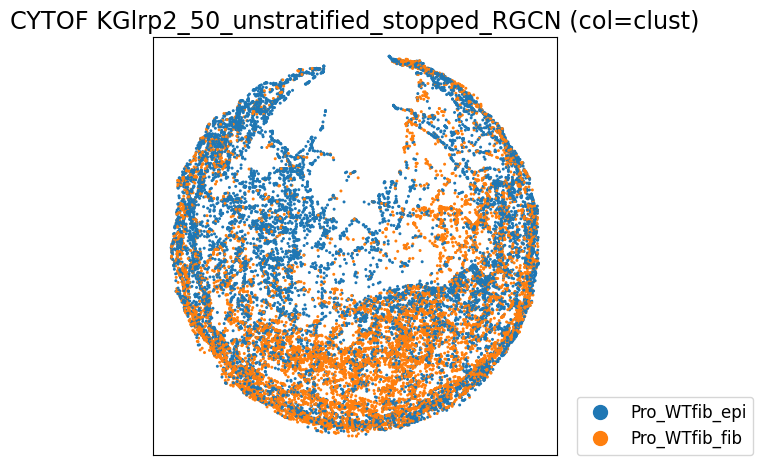

In [44]:
scprep.plot.scatter2d(
    data_phate, c=mdCYT,
    title=f"CYTOF {modelKGE} (col=clust)",
    shuffle=True, ticks=None,
    legend_loc=(1.05, 0))
scprep.plot.scatter2d(
    data_phate, c=dScalCyt["CASP3"],
    title="CyTOF KGE(col= scal Caspase)", 
    shuffle=True,ticks=None,
    legend_loc=(1.05, 0))
scprep.plot.scatter2d(
    data_phate, c=dMagicCyt["CASP3"],
    title="CyTOF KGE(col= magic Caspase)", 
    shuffle=True,ticks=None,
    legend_loc=(1.05, 0))
scprep.plot.scatter2d(
    data_phate, c=dScalCyt["p-\S*S8\S*-RB1"],
    title="CyTOF KGE(col=pRB1)", 
    shuffle=True,ticks=None,
    legend_loc=(1.05, 0))
scprep.plot.scatter2d(
    data_phate, c=dMagicCyt["p-\S*S8\S*-RB1"],
    title="CyTOF KGE(col=pRB1)", 
    shuffle=True,ticks=None,
    legend_loc=(1.05, 0))

## scRNAseq

In [46]:
#Multiply 2 matrices using the dot product
seq_projection = np.dot(dScalRnaSeq, wavloc.FlatWaves)
print(seq_projection.shape) #Shape should be cellsXwavelets
seq_projection

(3698, 846)


array([[-0.00313566, -0.02061799, -0.05448754, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00345449, -0.02004479, -0.05552107, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00241614, -0.02081752, -0.05355126, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00591878, -0.02825904, -0.09038026, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00291569, -0.02929374, -0.07234676, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00336891, -0.0274525 , -0.08309953, ...,  0.        ,
         0.        ,  0.        ]])

In [47]:
print(np.isnan(np.sum(seq_projection)))

False


In [48]:
from sklearn.impute import SimpleImputer
seq_projection = SimpleImputer(strategy="constant").fit_transform(seq_projection)
print(np.isnan(np.sum(seq_projection)))

False


Calculating PHATE...
  Running PHATE on 3698 observations and 846 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.11 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.26 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.40 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.14 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.24 seconds.
  Calculated landmark operator in 4.49 seconds.
  Calculating optimal t...
    Automatically selected t = 51
  Calculated optimal t in 0.82 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.52 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.31 seconds.
Calculated PHATE in 10.54 seconds.


<AxesSubplot: title={'center': 'scRNAseq KGlrp2_50_unstratified_stopped_RGCN (col=clust)'}>

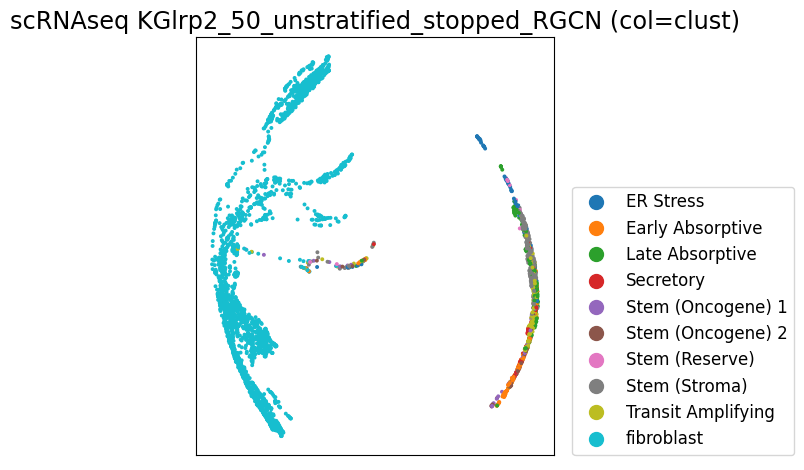

In [49]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(seq_projection) 
scprep.plot.scatter2d(
    data_phate, c=dSEQmd["finalPOPS"],
    title=f"scRNAseq {modelKGE} (col=clust)",
    shuffle=True, ticks=None,
    legend_loc=(1.05, 0))

## Both modalities

In [50]:
multi_projection = np.concatenate([seq_projection,cyt_projection])
multi_projection

array([[-0.00313566, -0.02061799, -0.05448754, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00345449, -0.02004479, -0.05552107, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00241614, -0.02081752, -0.05355126, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.07554119,
         0.10584409,  0.05658782],
       [ 0.        ,  0.        ,  0.        , ...,  0.20117702,
         0.27066231,  0.09092667],
       [ 0.        ,  0.        ,  0.        , ...,  0.07422743,
         0.11230731,  0.05845682]])

In [51]:
print(np.isnan(np.sum(multi_projection)))

False


In [52]:
np.savez_compressed(f"{data_dir}/multi_projection_KGlrp2_RGCN_WTfib.npz", seq_projection=seq_projection, cyt_projection=cyt_projection )

In [53]:
np.concatenate([dSEQmd["finalPOPS"],mdCYT])

array(['fibroblast', 'fibroblast', 'fibroblast', ..., 'Pro_WTfib_epi',
       'Pro_WTfib_epi', 'Pro_WTfib_epi'], dtype=object)

In [54]:
data_phate = phate.PHATE(n_jobs=-2, random_state=12).fit_transform(multi_projection) 
# scprep.plot.scatter2d(
#     data_phate, c=dSEQmd["finalPOPS"],
#     title="CYTOF cells on communication KG (col=clust)",
#     shuffle=True, ticks=None,
#     legend_loc=(1.05, 0))

Calculating PHATE...
  Running PHATE on 26843 observations and 846 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.73 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.58 seconds.
    Calculating affinities...
    Calculated affinities in 0.17 seconds.
  Calculated graph and diffusion operator in 5.50 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.18 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.04 seconds.
  Calculated landmark operator in 7.78 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 1.03 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.46 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.74 seconds.
Calculated PHATE in 19.52 seconds.


<AxesSubplot: title={'center': 'ALLcells KGlrp2_50_unstratified_stopped_RGCN (col=clust)'}>

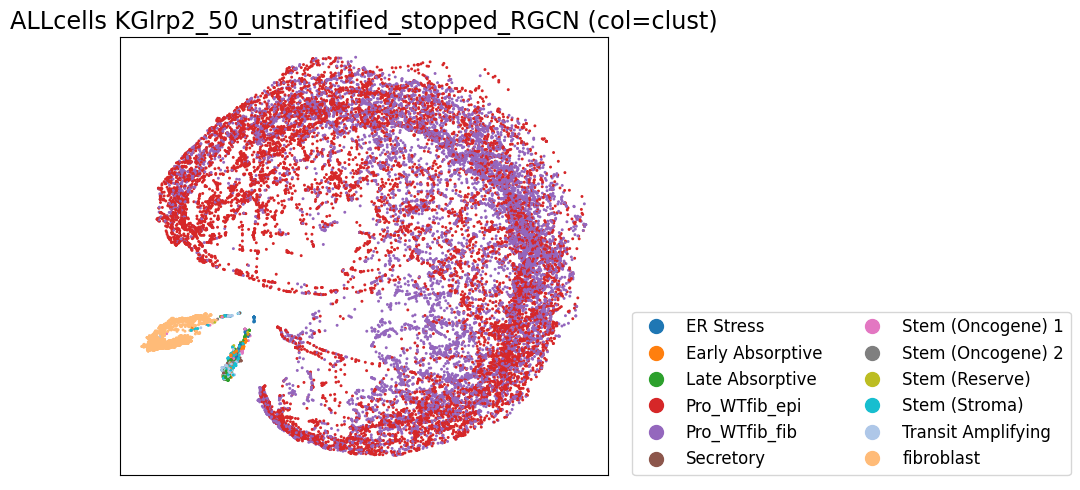

In [55]:
scprep.plot.scatter2d(
    data_phate, c=np.concatenate([dSEQmd["finalPOPS"],mdCYT]),
    title=f"ALLcells {modelKGE} (col=clust)",
    shuffle=True, ticks=None,
    figsize=(10,5), legend_loc=(1.05, 0))

# Correlation of LR in scRNAseq data

In [61]:
dftestcorr = dMagicRnaSeq.corr()
dftestcorr

,ACVR1,ACVR1B,ACVR2A,ACVR2B,ACVRL1,AMH,AMHR2,AR,BAMBI,BMP2,...,WNT16,WNT2,WNT2B,WNT4,WNT5A,WNT5B,WNT6,WNT7A,WNT7B,WNT9A
ACVR1,1.000000,0.106673,0.079809,-0.467618,0.117872,0.241297,0.061813,0.124426,0.649786,-0.503928,...,0.302013,0.667115,0.177243,0.362564,0.791661,0.299898,-0.025403,-0.330982,-0.380716,0.228429
ACVR1B,0.106673,1.000000,0.240423,-0.171775,-0.052917,0.163107,0.213070,0.091074,0.506469,-0.182888,...,0.566584,-0.263636,0.390920,0.643126,0.143304,0.642787,-0.018297,-0.336400,-0.327388,0.070505
ACVR2A,0.079809,0.240423,1.000000,0.029361,0.228373,0.090303,0.129161,0.165042,0.144283,0.230887,...,-0.063257,-0.096206,-0.020626,-0.054077,0.090265,0.071817,-0.179772,-0.037614,-0.043424,-0.185413
ACVR2B,-0.467618,-0.171775,0.029361,1.000000,-0.146364,-0.226123,-0.152577,-0.214601,-0.529408,0.470027,...,-0.382734,-0.266511,-0.183841,-0.491156,-0.570371,-0.423314,0.147330,0.501103,0.582574,0.055862
ACVRL1,0.117872,-0.052917,0.228373,-0.146364,1.000000,0.202006,0.202740,0.884790,0.078866,-0.193599,...,-0.351642,-0.084644,-0.193382,-0.078882,0.442965,0.177331,-0.154039,-0.210836,-0.256910,-0.286773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WNT5B,0.299898,0.642787,0.071817,-0.423314,0.177331,0.238655,0.135493,0.355776,0.771205,-0.519342,...,0.664818,-0.115472,0.494304,0.796616,0.436655,1.000000,-0.134686,-0.442857,-0.523726,0.155279
WNT6,-0.025403,-0.018297,-0.179772,0.147330,-0.154039,-0.081573,-0.179236,-0.150352,-0.160273,-0.054746,...,-0.086629,0.229015,-0.037391,-0.148971,-0.051627,-0.134686,1.000000,-0.139336,-0.069503,0.013324
WNT7A,-0.330982,-0.336400,-0.037614,0.501103,-0.210836,-0.204245,-0.174485,-0.279871,-0.513455,0.465094,...,-0.328482,-0.224047,-0.183889,-0.476803,-0.569457,-0.442857,-0.139336,1.000000,0.910086,0.186231
WNT7B,-0.380716,-0.327388,-0.043424,0.582574,-0.256910,-0.239403,-0.216046,-0.334392,-0.590813,0.563119,...,-0.379963,-0.242438,-0.216935,-0.561807,-0.660108,-0.523726,-0.069503,0.910086,1.000000,0.195871


In [63]:
dLRpath = pd.read_csv(f"{data_dir}/dLRpath.csv.tar.gz")
dLRpath

,head,relation,tail
0,TGFB1,Signaling by TGFB family members,TGFBR1
1,TGFB1,Signaling by TGFB family members,TGFBR2
2,TGFB2,Signaling by TGFB family members,TGFBR1
3,TGFB2,Signaling by TGFB family members,TGFBR2
4,TGFB3,Signaling by TGFB family members,TGFBR1
...,...,...,...
305,LTA,Signaling by WNT,LTB
306,F2,Signaling by TGFB family members,PARD3
307,COL1A2,Signaling by TGFB family members,ITGB1
308,COL1A2,Signaling by TGFB family members,ITGAV


In [65]:
dftestcorr = dftestcorr.reindex(index=dLRpath["head"], columns=dLRpath["tail"])
dftestcorr

tail,TGFBR1,TGFBR2,TGFBR1,TGFBR2,TGFBR1,TGFBR2,ACVR1,ACVR2A,ACVR1B,ACVR2B,...,FZD8,FZD2,FZD4,FZD5,FZD8,LTB,PARD3,ITGB1,ITGAV,ITGB8
head,,,,,,,,,,,,,,,,,,,,,
TGFB1,0.242982,0.142030,0.242982,0.142030,0.242982,0.142030,0.750175,-0.194909,-0.234047,-0.339189,...,0.300256,0.585109,0.150838,-0.473071,0.300256,-0.461284,-0.180707,0.582979,0.106194,-0.024500
TGFB1,0.242982,0.142030,0.242982,0.142030,0.242982,0.142030,0.750175,-0.194909,-0.234047,-0.339189,...,0.300256,0.585109,0.150838,-0.473071,0.300256,-0.461284,-0.180707,0.582979,0.106194,-0.024500
TGFB2,0.364410,0.735877,0.364410,0.735877,0.364410,0.735877,0.608861,-0.108292,0.460630,-0.543896,...,0.734328,0.789210,0.462920,-0.678296,0.734328,-0.656591,0.300976,0.181636,-0.238172,-0.086338
TGFB2,0.364410,0.735877,0.364410,0.735877,0.364410,0.735877,0.608861,-0.108292,0.460630,-0.543896,...,0.734328,0.789210,0.462920,-0.678296,0.734328,-0.656591,0.300976,0.181636,-0.238172,-0.086338
TGFB3,0.624711,0.185464,0.624711,0.185464,0.624711,0.185464,0.651357,0.088844,-0.066088,-0.401614,...,0.542737,0.683809,0.438569,-0.556048,0.542737,-0.522541,0.179395,0.660768,-0.032176,0.399378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F2,-0.036995,0.130358,-0.036995,0.130358,-0.036995,0.130358,0.362614,-0.142820,-0.055811,-0.245917,...,0.108050,0.311670,0.074806,-0.311783,0.108050,-0.290511,-0.209199,0.047068,-0.076757,-0.257745
COL1A2,0.801319,0.561510,0.801319,0.561510,0.801319,0.561510,0.683665,0.070361,0.382836,-0.600896,...,0.878117,0.897646,0.554052,-0.836759,0.878117,-0.744739,0.477412,0.454254,-0.263886,0.418736


In [83]:
dftestcorr.dropna(how="all")

tail,TGFBR1,TGFBR2,TGFBR1,TGFBR2,TGFBR1,TGFBR2,ACVR1,ACVR2A,ACVR1B,ACVR2B,...,FZD8,FZD2,FZD4,FZD5,FZD8,LTB,PARD3,ITGB1,ITGAV,ITGB8
head,,,,,,,,,,,,,,,,,,,,,
TGFB1,0.242982,0.142030,0.242982,0.142030,0.242982,0.142030,0.750175,-0.194909,-0.234047,-0.339189,...,0.300256,0.585109,0.150838,-0.473071,0.300256,-0.461284,-0.180707,0.582979,0.106194,-0.024500
TGFB1,0.242982,0.142030,0.242982,0.142030,0.242982,0.142030,0.750175,-0.194909,-0.234047,-0.339189,...,0.300256,0.585109,0.150838,-0.473071,0.300256,-0.461284,-0.180707,0.582979,0.106194,-0.024500
TGFB2,0.364410,0.735877,0.364410,0.735877,0.364410,0.735877,0.608861,-0.108292,0.460630,-0.543896,...,0.734328,0.789210,0.462920,-0.678296,0.734328,-0.656591,0.300976,0.181636,-0.238172,-0.086338
TGFB2,0.364410,0.735877,0.364410,0.735877,0.364410,0.735877,0.608861,-0.108292,0.460630,-0.543896,...,0.734328,0.789210,0.462920,-0.678296,0.734328,-0.656591,0.300976,0.181636,-0.238172,-0.086338
TGFB3,0.624711,0.185464,0.624711,0.185464,0.624711,0.185464,0.651357,0.088844,-0.066088,-0.401614,...,0.542737,0.683809,0.438569,-0.556048,0.542737,-0.522541,0.179395,0.660768,-0.032176,0.399378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WNT11,-0.055452,-0.045255,-0.055452,-0.045255,-0.055452,-0.045255,0.538001,-0.217569,-0.400464,-0.166221,...,0.024945,0.319959,-0.046042,-0.151434,0.024945,-0.225048,-0.391652,0.459414,0.182866,-0.167060
F2,-0.036995,0.130358,-0.036995,0.130358,-0.036995,0.130358,0.362614,-0.142820,-0.055811,-0.245917,...,0.108050,0.311670,0.074806,-0.311783,0.108050,-0.290511,-0.209199,0.047068,-0.076757,-0.257745
COL1A2,0.801319,0.561510,0.801319,0.561510,0.801319,0.561510,0.683665,0.070361,0.382836,-0.600896,...,0.878117,0.897646,0.554052,-0.836759,0.878117,-0.744739,0.477412,0.454254,-0.263886,0.418736


<AxesSubplot: xlabel='tail', ylabel='head'>

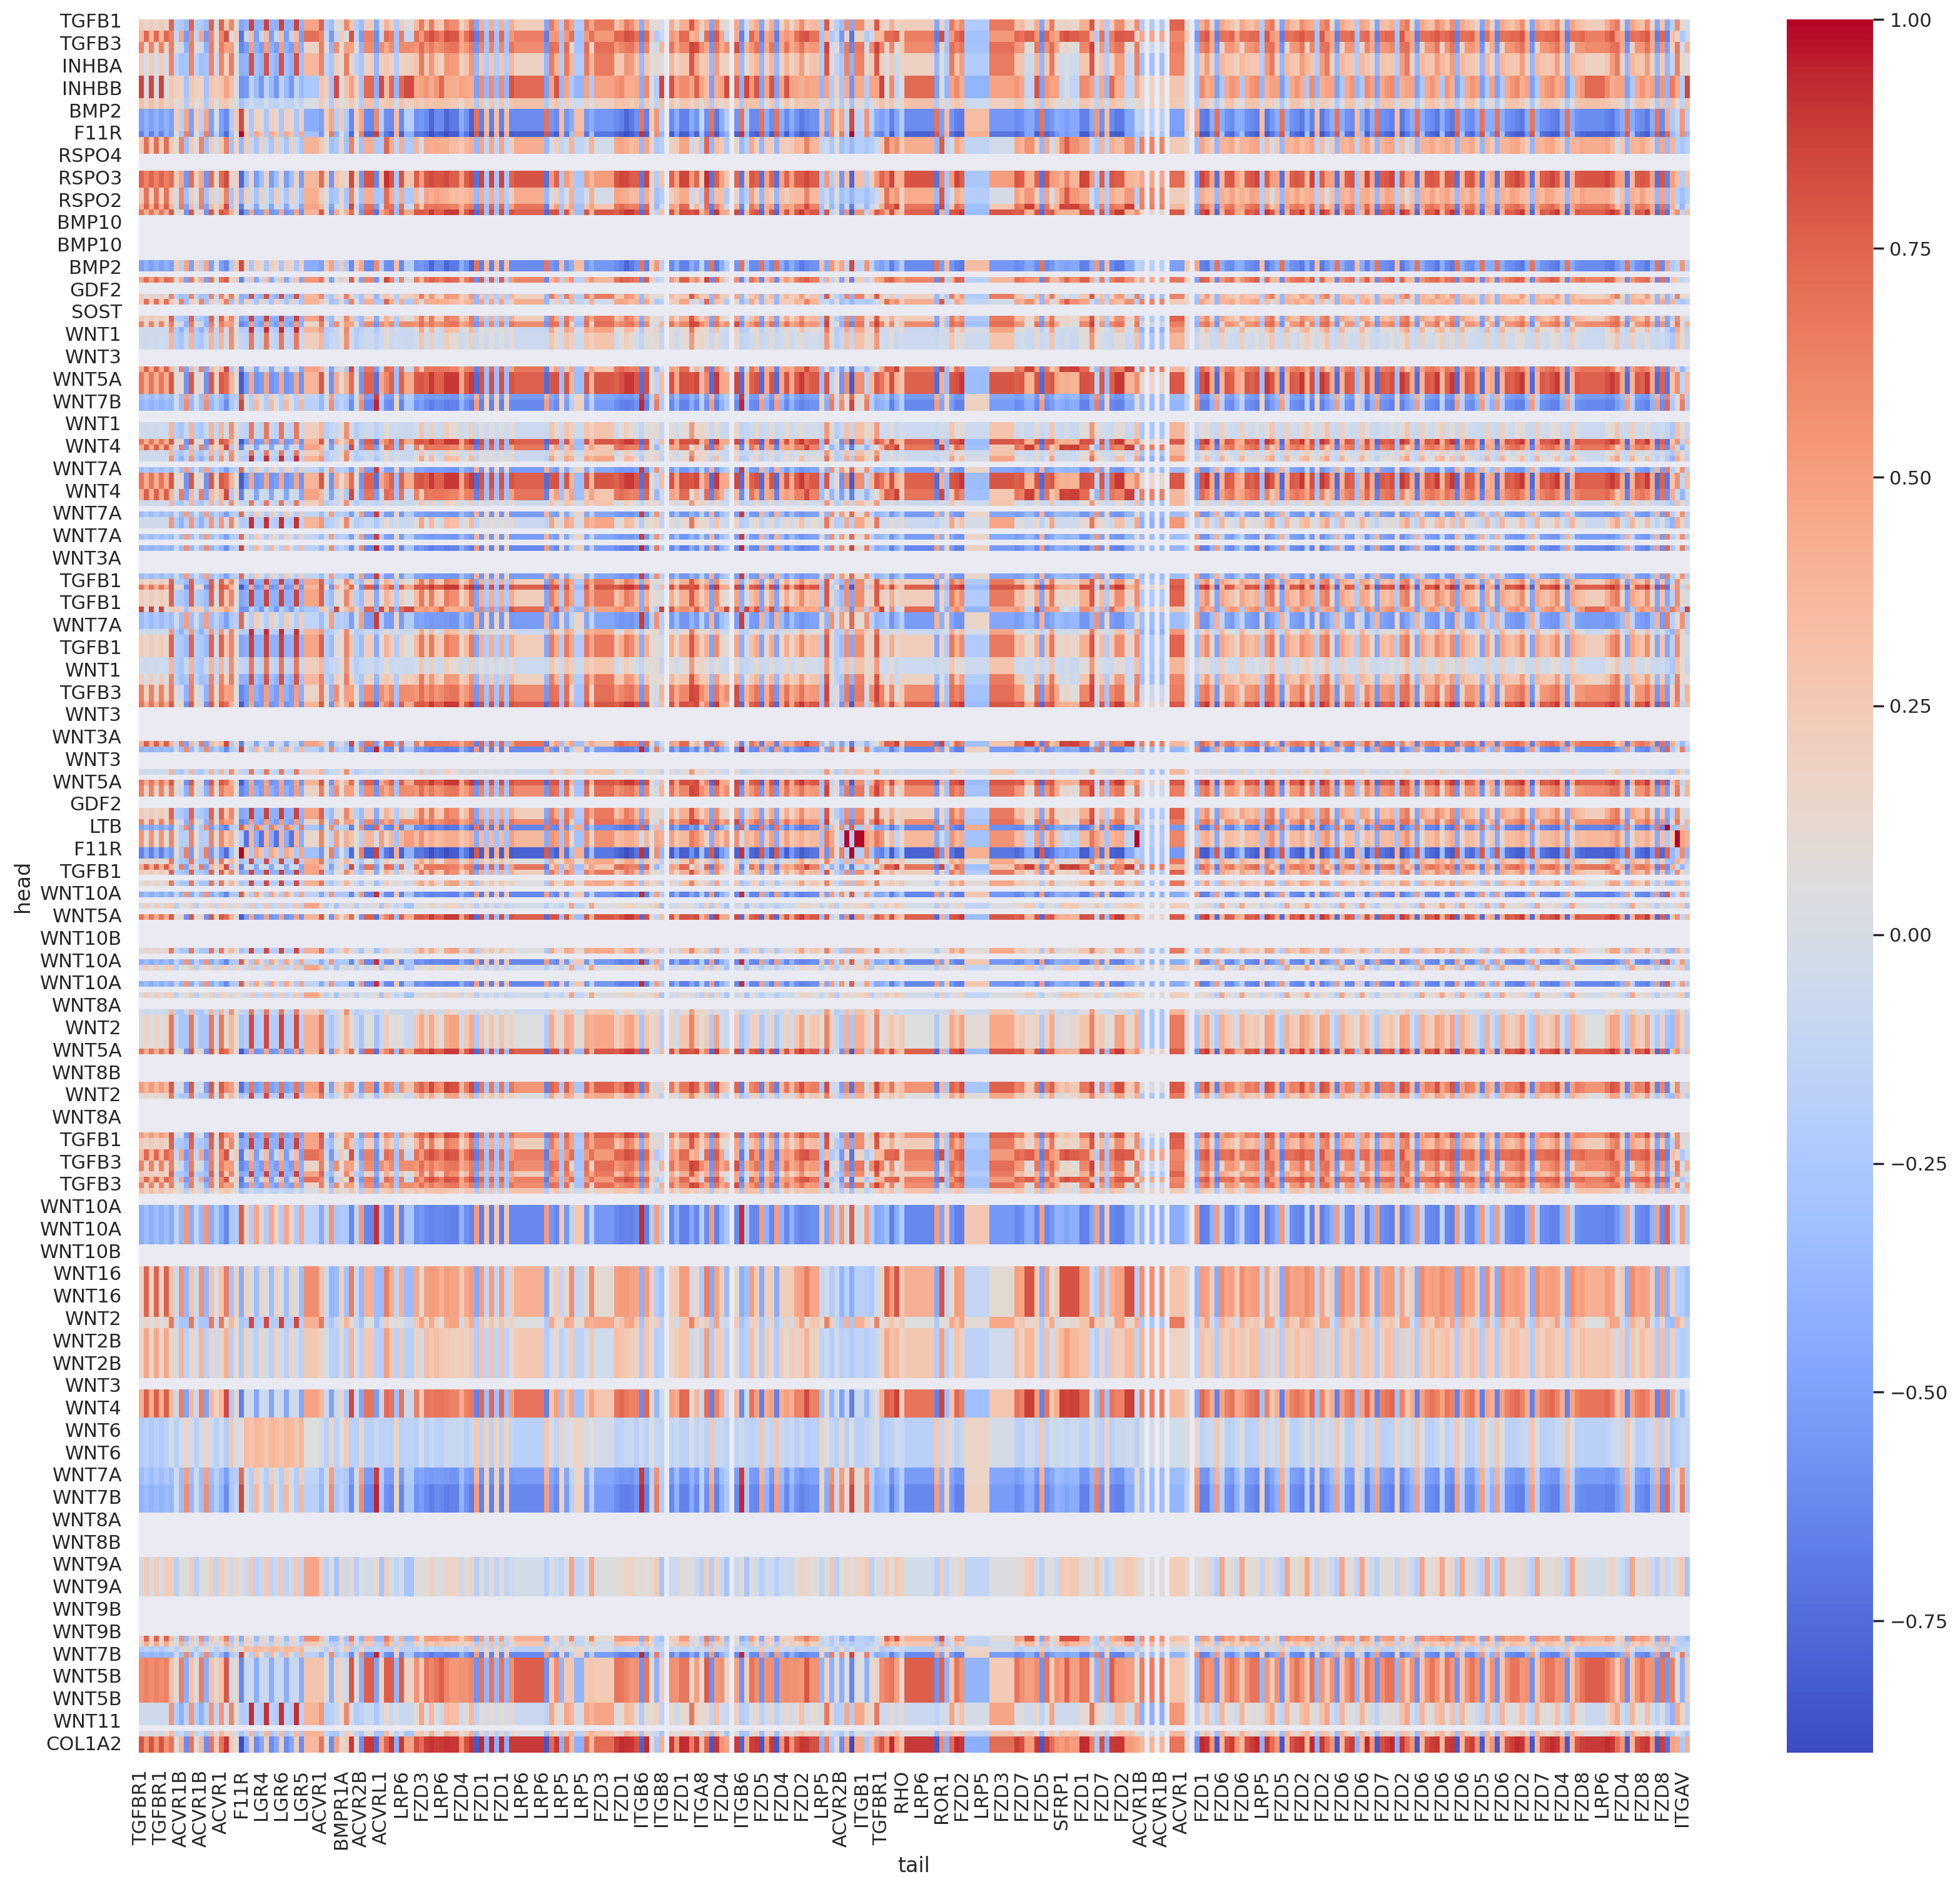

In [85]:
%config InlineBackend.figure_format = "retina"

import seaborn as sns


sns.set(rc={"figure.figsize":(20,18)})
sns.heatmap(dftestcorr, cmap="coolwarm")